In [1]:
import numpy as np
import pandas as pd

from pathlib import Path
from mediapipe import solutions

from utils import *
from data_utils import prepare_dataframe, generate_dataframe
from custom_pose_landmarks import CustomPoseLandmark

import math
import numpy as np

import matplotlib.pyplot as plt

In [2]:
# Selected values of pose landmarks corresponding to PoseLandmark class from MediaPipe library
values = [0, 11, 12, 13, 14, 15, 16, 19, 20, 23, 24, 25, 26, 27, 28, 31, 32]

# Custom pose landmark names
landmarks = {
    'THORAX': ['NOSE'],
    'PELVIS': ['LEFT_HIP', 'RIGHT_HIP'],
}

# MediaPipe solutions
mp_drawing = solutions.drawing_utils
mp_pose = solutions.pose


pose = CustomPoseLandmark(mp_pose, values, landmarks)

In [3]:
import cv2

In [345]:
custom_pose = CustomPoseLandmark(mp_pose, values)

source = Path('../data/raw/squat/movie_01.mp4')
dataframe = prepare_dataframe(custom_pose)
dataframe2 = prepare_dataframe(custom_pose)
Id = source.name.split('.')[0]
time = 0 
cap = cv2.VideoCapture(source.__str__())


with mp_pose.Pose(
    min_detection_confidence=0.5,
    min_tracking_confidence=0.5,
    enable_segmentation=False
) as pose:
    while cap.isOpened():
        ret, image = cap.read()
        if ret:
            time += 1
            
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image.flags.writeable = False
            results = pose.process(image)
            image.flags.writeable = True
            image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

            landmark_list = get_custom_landmarks(
                mp_pose=mp_pose,
                custom_pose=custom_pose,
                landmarks=results.pose_landmarks)



##########################################################################
            
            # rotation
            # roll, pitch yaw axes
    
            default_angle = math.pi / 4

            left_hip = landmark_list.landmark[
                custom_pose.get_value(mp_pose.PoseLandmark.LEFT_HIP)
            ]

            right_hip = landmark_list.landmark[
                custom_pose.get_value(mp_pose.PoseLandmark.RIGHT_HIP)
            ]


            angle = math.atan((left_hip.z - right_hip.z) / (left_hip.x - right_hip.x))
            alpha = default_angle - angle

            def rotation(vector, alpha):

                rotation_matrix = np.array(
                    [
                        [math.cos(alpha), 0, math.sin(alpha)],
                        [0, 1, 0],
                        [-math.sin(alpha), 0, math.cos(alpha)],
                    ]
                )
                
                return np.dot(rotation_matrix, vector)

    
            # rotation([left_hip.x, left_hip.z], alpha)
                        


            record = [Id, time]
            
            # Create record containing video id, actual time and pose landmark coordinates
            for landmark in landmark_list.landmark:
                # Extract pose landmarks coordinates and store as array
                coordinates = landmark2array(landmark)[:3]
                record += coordinates.tolist()

            # Save collected data in DataFrame format
            dataframe = pd.concat(
                [dataframe, pd.DataFrame([record], columns=dataframe.columns)],
                ignore_index=True
            )



            record2 = [Id, time]
            
            # Create record containing video id, actual time and pose landmark coordinates
            for landmark in landmark_list.landmark:
                # Extract pose landmarks coordinates and store as array
                coordinates = landmark2array(landmark)[:3]
                # rotation
                coordinates = rotation(coordinates, alpha)

                record2 += coordinates.tolist()

            # Save collected data in DataFrame format
            dataframe2 = pd.concat(
                [dataframe2, pd.DataFrame([record2], columns=dataframe2.columns)],
                ignore_index=True
            )


            #dataframe['timestamp'] = pd.to_timedelta(dataframe['timestamp'], unit='s')
            

############################################################################       
            
        else:
            break

cap.release()
cv2.destroyAllWindows()

In [56]:
# rotation
# roll, pitch yaw axes

default_angle = math.pi / 4

left_hip = landmark_list.landmark[
    custom_pose.get_value(mp_pose.PoseLandmark.LEFT_HIP)
]

right_hip = landmark_list.landmark[
    custom_pose.get_value(mp_pose.PoseLandmark.RIGHT_HIP)
]


angle = math.atan((left_hip.z - right_hip.z) / (left_hip.x - right_hip.x))
alpha = math.degrees(default_angle - angle)

def rotation(vector, alpha):

    rotation_matrix = np.array(
        [[math.cos(alpha), -math.sin(alpha)],
        [math.sin(alpha), math.cos(alpha)]]
        )
    
    return np.dot(rotation_matrix, vector)


rotation([left_hip.x, left_hip.z], alpha)

array([-0.53386087, -0.23673773])

In [343]:
math.radians(180)

3.141592653589793

In [238]:
data = np.array([
    [-0.5, -0.6, -0.5],
    [0.0001, -0.1, 0.0001],
    [0.5, 0.4, 0.5]
])

data2 = data.copy()

for i in range(3):
    data2[i, [0, 2]] = rotation(data[i, [0, 2]], alpha=-math.pi / 4)

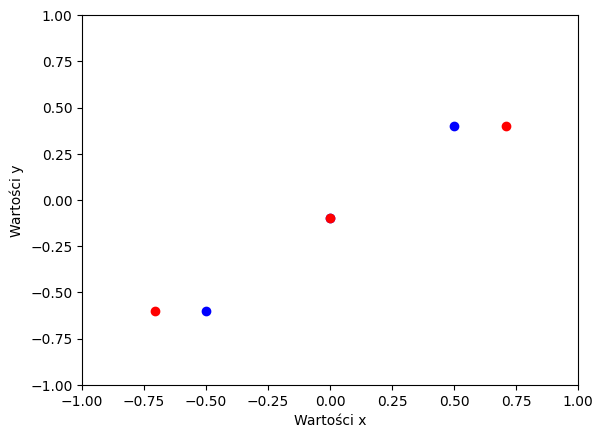

In [239]:
x = data[:, 0]
y = data[:, 1]
plt.scatter(x, y, marker='o', color='blue')

x2 = data2[:, 0]
y2 = data2[:, 1]
plt.scatter(x2, y2, marker='o', color='red')

plt.xlabel('Wartości x')
plt.ylabel('Wartości y')

plt.xlim((-1, 1))
plt.ylim((-1, 1))

plt.show()

In [355]:
df = dataframe.iloc[:, 2:]
df = df.iloc[10, [col_idx for col_idx in range(df.shape[1]) if col_idx % 3 != 2]]
data = df.to_numpy().reshape((18, -1))

In [356]:
df2 = dataframe2.iloc[:, 2:]
df2 = df2.iloc[10, [col_idx for col_idx in range(df2.shape[1]) if col_idx % 3 != 2]]
data2 = df2.to_numpy().reshape((18, -1))

In [420]:
def linear_regression(X, Y):
    """
    
    """
    X_hat = np.mean(X)
    Y_hat = np.mean(Y)

    numerator = np.sum((X - X_hat) * (Y - Y_hat))
    denominator = np.sum((X - X_hat) ** 2)

    m = numerator / denominator
    b = Y_hat - m * X_hat

    return m, b

In [427]:
np.arange(0, 1, .1)

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

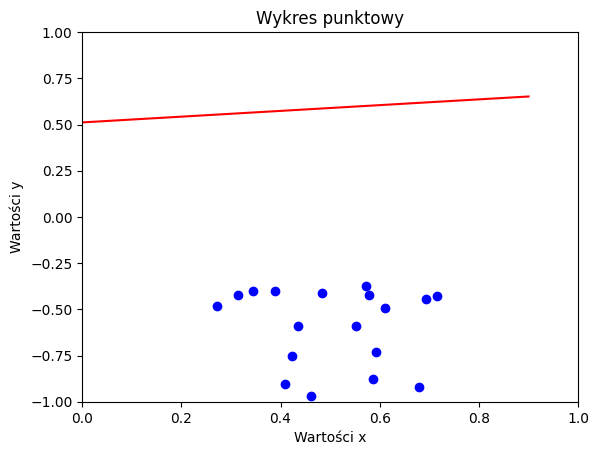

In [428]:
x_values = data[:, 0]
y_values = data[:, 1]

# Narysuj punkty
plt.scatter(x_values, -y_values, marker='o', color='blue')


#
slope, intercept = linear_regression(x_values, y_values)
x = np.arange(0, 1, .1)
y = slope * x + intercept

plt.plot(x, y, 'red')

# x_rotated_values = data2[:, 0]
# y_rotated_values = data2[:, 1]

# plt.scatter(x_rotated_values, -y_rotated_values, marker='o', color='red')


# Dodaj etykiety osi
plt.xlabel('Wartości x')
plt.ylabel('Wartości y')

plt.xlim((0, 1))
plt.ylim((-1, 1))
# Dodaj tytuł wykresu
plt.title('Wykres punktowy')

# Wyświetl wykres
plt.show()

In [6]:
def linear_regression(X, Y):
    """
    
    """
    X_hat = np.mean(X)
    Y_hat = np.mean(Y)

    numerator = np.sum((X - X_hat) * (Y - Y_hat))
    denominator = np.sum((X - X_hat) ** 2)

    m = numerator / denominator
    b = Y_hat - m * X_hat

    return m, b

In [8]:
data = np.array([0.56681758, 0.3466295 , 0.60460711, 0.41470891, 0.40318498,
       0.40646446, 0.64005053, 0.50206786, 0.28999114, 0.48238835,
       0.71496195, 0.45273143, 0.31366521, 0.42939883, 0.72912896,
       0.43998319, 0.33389136, 0.40628907, 0.56860369, 0.59095776,
       0.44493255, 0.58893925, 0.59271342, 0.7313506 , 0.4410978 ,
       0.74279314, 0.5841772 , 0.87851113, 0.3944287 , 0.8815046 ,
       0.67098927, 0.92997348, 0.43547872, 0.95368195, 0.50389606,
       0.41058668]).reshape((18, -1))

x_values = data[:, 0]
y_values = data[:, 1]

In [13]:
linear_regression(x_values, y_values)

(0.0695857839652011, 0.5525834084214228)

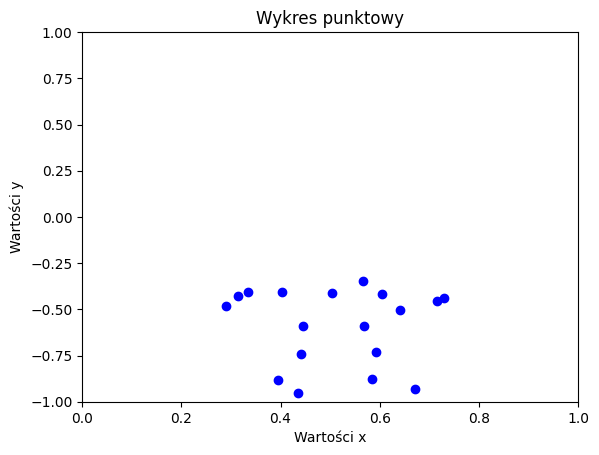

In [7]:
x_values = data[:, 0]
y_values = data[:, 1]

# Narysuj punkty
plt.scatter(x_values, -y_values, marker='o', color='blue')

# x_rotated_values = rotated_data[:, 0]
# y_rotated_values = rotated_data[:, 1]

# plt.scatter(x_rotated_values, -y_rotated_values, marker='o', color='red')

# Dodaj etykiety osi
plt.xlabel('Wartości x')
plt.ylabel('Wartości y')

plt.xlim((0, 1))
plt.ylim((-1, 1))
# Dodaj tytuł wykresu
plt.title('Wykres punktowy')

# Wyświetl wykres
plt.show()

In [115]:
df = dataframe.copy()
df.head()

,Id,timestamp,nose_x,nose_y,nose_z,left_shoulder_x,left_shoulder_y,left_shoulder_z,right_shoulder_x,right_shoulder_y,...,right_ankle_z,left_foot_index_x,left_foot_index_y,left_foot_index_z,right_foot_index_x,right_foot_index_y,right_foot_index_z,thorax_x,thorax_y,thorax_z
0,movie_01,0 days 00:00:01,0.580823,0.373949,-0.130844,0.590139,0.420385,0.258104,0.408871,0.406552,...,-0.003425,0.668166,0.925310,-0.104012,0.452521,0.943272,-0.218862,0.499505,0.413469,0.100992
1,movie_01,0 days 00:00:02,0.580109,0.374057,-0.171805,0.589022,0.421825,0.256697,0.405288,0.406545,...,-0.083875,0.668756,0.923911,0.066587,0.458898,0.963448,-0.300432,0.497155,0.414185,0.100827
2,movie_01,0 days 00:00:03,0.579587,0.373618,-0.196401,0.586828,0.422206,0.259244,0.401607,0.406396,...,-0.120507,0.670330,0.923771,0.010502,0.462133,0.965745,-0.345503,0.494218,0.414301,0.104741
3,movie_01,0 days 00:00:04,0.578398,0.373395,-0.155779,0.583670,0.423076,0.273894,0.396469,0.406258,...,-0.139764,0.672433,0.923779,0.065552,0.462895,0.966466,-0.361849,0.490070,0.414667,0.128030
4,movie_01,0 days 00:00:05,0.576812,0.373007,-0.156062,0.582043,0.423559,0.287268,0.395252,0.406536,...,-0.165116,0.674551,0.923631,0.031309,0.463939,0.967741,-0.386876,0.488648,0.415048,0.132819


In [80]:
slope = (df['left_hip_z'] - df['right_hip_z']) / (df['left_hip_x'] - df['right_hip_x'])
slope.apply(lambda x: np.degrees(np.arctan(x)))

0      64.056372
1      65.006610
2      65.841189
3      65.298268
4      65.864820
         ...    
753    58.062252
754    59.566113
755    59.988196
756    60.399184
757    60.459410
Length: 758, dtype: float64

In [114]:
for pose_name in pose.get_landmarks().values():
    x = '_'.join([pose_name, 'x']).lower()
    z = '_'.join([pose_name, 'z']).lower()
    
    print(df[[x, z]])
    break

    

       nose_x    nose_z
0    0.580823 -0.130844
1    0.580109 -0.171805
2    0.579587 -0.196401
3    0.578398 -0.155779
4    0.576812 -0.156062
..        ...       ...
753  0.658498 -0.346511
754  0.658315 -0.340443
755  0.658085 -0.344377
756  0.659487 -0.334723
757  0.660342 -0.332929

[758 rows x 2 columns]


In [104]:
'_'.join([pose_name, 'x']).lower()

'thorax_x'

In [111]:
df['nose_x'].mean()

0.5880775375778253

In [86]:
df.iloc[:, 2:]

,nose_x,nose_y,nose_z,left_shoulder_x,left_shoulder_y,left_shoulder_z,right_shoulder_x,right_shoulder_y,right_shoulder_z,left_elbow_x,...,right_ankle_z,left_foot_index_x,left_foot_index_y,left_foot_index_z,right_foot_index_x,right_foot_index_y,right_foot_index_z,thorax_x,thorax_y,thorax_z
0,0.580823,0.373949,-0.130844,0.590139,0.420385,0.258104,0.408871,0.406552,-0.056120,0.623835,...,-0.003425,0.668166,0.925310,-0.104012,0.452521,0.943272,-0.218862,0.499505,0.413469,0.100992
1,0.580109,0.374057,-0.171805,0.589022,0.421825,0.256697,0.405288,0.406545,-0.055043,0.622396,...,-0.083875,0.668756,0.923911,0.066587,0.458898,0.963448,-0.300432,0.497155,0.414185,0.100827
2,0.579587,0.373618,-0.196401,0.586828,0.422206,0.259244,0.401607,0.406396,-0.049763,0.617302,...,-0.120507,0.670330,0.923771,0.010502,0.462133,0.965745,-0.345503,0.494218,0.414301,0.104741
3,0.578398,0.373395,-0.155779,0.583670,0.423076,0.273894,0.396469,0.406258,-0.017835,0.615290,...,-0.139764,0.672433,0.923779,0.065552,0.462895,0.966466,-0.361849,0.490070,0.414667,0.128030
4,0.576812,0.373007,-0.156062,0.582043,0.423559,0.287268,0.395252,0.406536,-0.021629,0.613107,...,-0.165116,0.674551,0.923631,0.031309,0.463939,0.967741,-0.386876,0.488648,0.415048,0.132819
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
753,0.658498,0.398700,-0.346511,0.653447,0.412709,0.028678,0.451234,0.400925,-0.276940,0.629738,...,-0.253499,0.682742,0.929045,0.019837,0.495079,0.962665,-0.503195,0.552340,0.406817,-0.124131
754,0.658315,0.399100,-0.340443,0.649908,0.414128,0.031337,0.451214,0.401635,-0.275858,0.626367,...,-0.243779,0.683154,0.928975,-0.018784,0.494399,0.962366,-0.487393,0.550561,0.407881,-0.122260
755,0.658085,0.399755,-0.344377,0.647498,0.415599,0.024658,0.451723,0.402546,-0.285755,0.626389,...,-0.260447,0.682915,0.928881,0.000766,0.493094,0.961935,-0.505302,0.549611,0.409072,-0.130549
756,0.659487,0.400034,-0.334723,0.647505,0.417092,0.023852,0.452356,0.402892,-0.285324,0.624691,...,-0.256256,0.683386,0.928600,0.004056,0.493059,0.961997,-0.502165,0.549930,0.409992,-0.130736


In [81]:
def rotation(v, alpha):

    matrix = np.array(
        [[math.cos(alpha), -math.sin(alpha)],
        [math.sin(alpha), math.cos(alpha)]]
        )
    
    return np.dot(matrix, v)

In [17]:
# rotation

v = np.array([1, 0])
alpha = math.pi / 2

In [22]:
def rotation(v, alpha):

    matrix = np.array(
        [[math.cos(alpha), -math.sin(alpha)],
        [math.sin(alpha), math.cos(alpha)]]
        )
    
    return np.dot(matrix, v)

In [34]:
data = np.array([0.56681758, 0.3466295 , 0.60460711, 0.41470891, 0.40318498,
       0.40646446, 0.64005053, 0.50206786, 0.28999114, 0.48238835,
       0.71496195, 0.45273143, 0.31366521, 0.42939883, 0.72912896,
       0.43998319, 0.33389136, 0.40628907, 0.56860369, 0.59095776,
       0.44493255, 0.58893925, 0.59271342, 0.7313506 , 0.4410978 ,
       0.74279314, 0.5841772 , 0.87851113, 0.3944287 , 0.8815046 ,
       0.67098927, 0.92997348, 0.43547872, 0.95368195, 0.50389606,
       0.41058668])

In [35]:
data = np.reshape(data, (18, -1))

In [72]:
alpha = -math.pi / 16
rotated_data = np.empty((0, 2))

for point in data:
    rotated_data = np.append(rotated_data, [rotation(point, alpha)], axis=0)

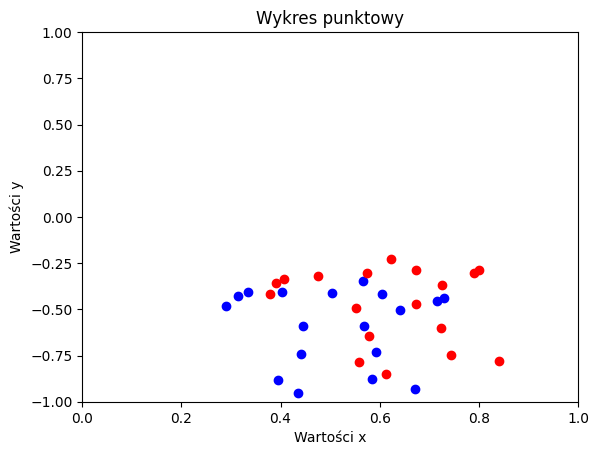

In [73]:
x_values = data[:, 0]
y_values = data[:, 1]

# Narysuj punkty
plt.scatter(x_values, -y_values, marker='o', color='blue')

x_rotated_values = rotated_data[:, 0]
y_rotated_values = rotated_data[:, 1]

plt.scatter(x_rotated_values, -y_rotated_values, marker='o', color='red')

# Dodaj etykiety osi
plt.xlabel('Wartości x')
plt.ylabel('Wartości y')

plt.xlim((0, 1))
plt.ylim((-1, 1))
# Dodaj tytuł wykresu
plt.title('Wykres punktowy')

# Wyświetl wykres
plt.show()